In [1]:
suppressMessages(library(Seurat))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(viridis))
suppressMessages(library(ggplot2))
options(warn=-1)

In [2]:
set.seed(42)
getwd()

[1] "/data/scATA/SingleCellOpenChromatin/local/VisiumHeartRevision/IntegrativeAnalysis/vSMCs/code"

In [3]:
df_anno <- read.csv("../../../visiumSpatial/metadata/sample_annotation.csv", header = TRUE)

patient_region_id <- df_anno$patient_region_id
patient_region_id <- stringr::str_replace_all(patient_region_id, "/", "_")

names(patient_region_id) <- df_anno$sample_id

In [6]:
names(patient_region_id)

[1] "AKK006_157771"   "Visium_1_CK279"  "Visium_3_CK281"  "Visium_4_CK282" 
 [5] "Visium_12_CK290" "Visium_13_CK291" "Visium_16_CK294" "Visium_14_CK292"
 [9] "AKK004_157772"   "Visium_11_CK289" "Visium_18_CK296" "Visium_9_CK287" 
[13] "Visium_19_CK297" "Visium_7_CK285"  "Visium_20_CK298" "Visium_15_CK293"
[17] "AKK002_157779"   "AKK003_157775"   "Visium_8_CK286"  "AKK002_157782"  
[21] "Visium_2_CK280"  "Visium_17_CK295" "Visium_6_CK284"  "Visium_10_CK288"
[25] "AKK003_157777"   "AKK002_157781"   "AKK001_157785"   "Visium_5_CK283"

In [4]:
if(!dir.exists("../data/visium/cell_states_mapping_with_annotation")){
    dir.create("../data/visium/cell_states_mapping_with_annotation", recursive = TRUE)
}

processing sample: Visium_19_CK297

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



[1] "vSMCs_1"                  "vSMCs_2"                 
[3] "perivascular_fibroblasts"


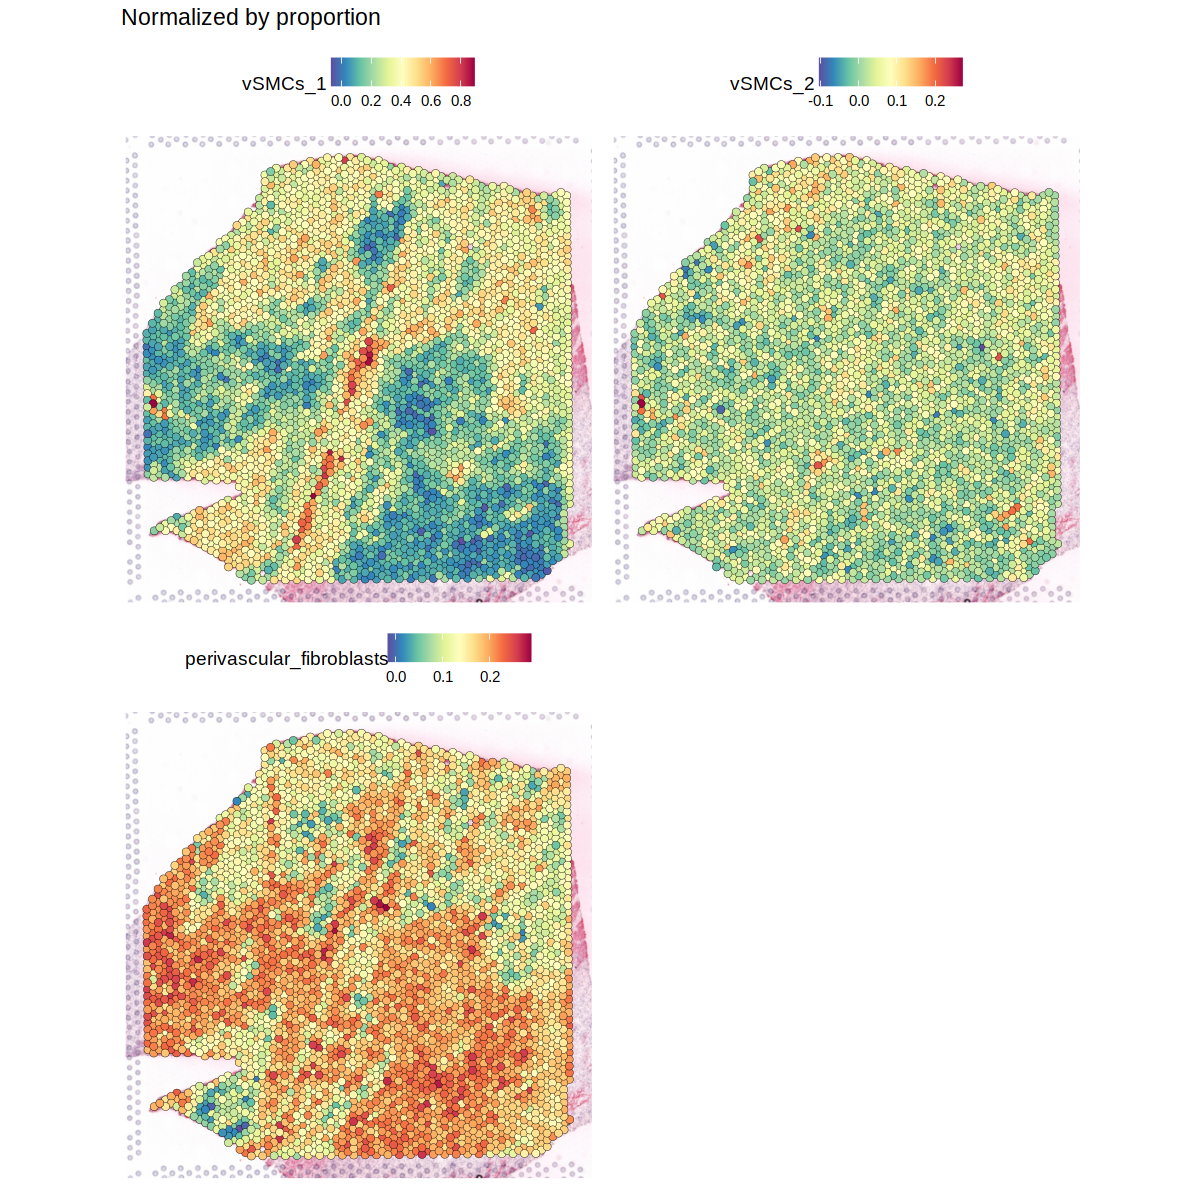

In [15]:
#for(sample in c("Visium_19_CK297")){
for(sample in names(patient_region_id)){
        message(glue::glue("processing sample: {sample}"))

        # load visium object
        obj <- readRDS(glue::glue("../../../visiumSpatial/from_rico/processed_visium/objects/{sample}.rds"))
    
        DefaultAssay(obj) <- "c2l_props"
        p1 <- SpatialFeaturePlot(obj, features = "vSMCs", max.cutoff = "q99") + ggtitle("c2l: proportion") +
    scale_fill_viridis()

         DefaultAssay(obj) <- "SCT"
        
        all.markers <- readRDS("../data/coembed/MarkerGenesAfterAnnotation/annotation.rds")
        
        # only keep genes that are found in spatial dta
        gene.use <- intersect(rownames(obj), rownames(all.markers))
        all.markers <- all.markers[gene.use, ]
        
        # get the marker genes for each cluster
        all.markers <- all.markers %>%
            subset(p_val_adj < 0.05) %>%
            subset(., select = c("cluster", "gene"))
        
        # convert dataframe to list for module score calculation
        all.markers <- split(all.markers, all.markers$cluster)
        
        for(cl in names(all.markers)){
           all.markers[[cl]] <- all.markers[[cl]]$gene 
        }
    
        # get module score
        obj <- AddModuleScore(obj, features = all.markers, assay = "SCT")
        
        df_module_score <- as.data.frame(obj@meta.data)%>%
             select(., contains("Cluster"))
        colnames(df_module_score) <- names(all.markers)
    
    celltypes <- names(all.markers)
    print(celltypes)
    
        # plot module score after normalization by proportion from cell2location
        c2l_score_prop <- obj@assays$c2l_props@data["vSMCs", ]
        df_module_score_prop <- df_module_score * c2l_score_prop
        df_module_score_prop[df_module_score_prop <0] <- 0
    
        obj <- AddMetaData(obj, metadata = df_module_score)
        plotlist <- SpatialFeaturePlot(obj, features = celltypes, combine = FALSE)
        plotlist <- lapply(1:length(plotlist), function(i){
          p <- plotlist[[i]] + theme(legend.title = element_blank()) +
           scale_fill_viridis() + ggtitle(celltypes[[i]])
          return(p)
        })
    
        ps1 <- patchwork::wrap_plots(plotlist, nrow = 2) +
            patchwork::plot_annotation(title = "Normalized by proportion")
        
        options(repr.plot.height = 10, repr.plot.width = 10)
    
        print(ps1)
        
        patient_region <- patient_region_id[sample]

        pdf(glue::glue("../data/visium/cell_states_mapping_with_annotation/{sample}_{patient_region}.pdf"), width = 20, height = 10)
        print(p1+ps1)
        dev.off()
    }